In [1]:
import os
os.chdir("../../../")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import scanpy as sc
import matplotlib
import scnet as sn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
sc.settings.set_figure_params(dpi=250)
sc.settings.figdir = "./results/integration/tabula_senis_muris/"

In [6]:
condition_key = "method_age"
cell_type_key = 'cell_ontology_class'
target_conditions = ["droplet - 3m", "facs - 3m"]

# Loading mouse brain datasets and data preparation

In [7]:
adata = sc.read("./data/tabula_senis_muris/tabula_senis_muris_normalized_hvg_subsampled.h5ad")
adata

AnnData object with n_obs × n_vars = 196548 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [8]:
adata_for_training = adata[~adata.obs['tissue'].isin(['Trachea'])]
adata_for_training = adata_for_training[~adata_for_training.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 105706 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 90120 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
adata_for_training.obs['Tech'] = 'Tabula Senis'
adata_out_of_sample.obs['Tech'] = 'Tabula Muris'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [11]:
train_adata, valid_adata = sn.utils.train_test_split(adata_for_training, 0.80)

In [12]:
train_adata.shape, valid_adata.shape

((84564, 2000), (21142, 2000))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

8

# Create & Train model with training data

In [14]:
network = sn.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[1024, 512, 128, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.1,
                             beta=1000,
                             eta=100,
                             clip_value=10.0,
                             loss_fn='mse',
                             mmd_computation_method='5',
                             model_path="./models/CVAE/tabula_senis/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [15]:
train_adata.obs[condition_key].value_counts()

droplet - 30m    17866
droplet - 18m    14316
droplet - 24m    12018
droplet - 21m    11440
facs - 18m       10646
facs - 24m        9750
droplet - 1m      8296
facs - 21m         232
Name: method_age, dtype: int64

In [16]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7}

## Training the network

In [17]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              n_per_epoch=0,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True, 
              retrain=False,
              verbose=5)

Model has been successfully restored!


In [18]:
network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7}

In [19]:
# encoder_labels, _ = sn.utils.label_encoder(
#     adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [20]:
# latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
# latent_adata

In [21]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [22]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_pretrain_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_pretrain_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_pretrain_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_pretrain_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Perfroming architecture Surgery

In [23]:
new_network = sn.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=False,
                              remove_dropout=False,
                              new_training_kwargs={"beta": 1000},
                              new_network_kwargs={"mmd_computation_method": "general"}
                             )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 1024)         2058240     data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 1024)         0           first_layer[0][0]                
__________

In [24]:
new_network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 21m': 6,
 'facs - 24m': 7,
 'droplet - 3m': 8,
 'facs - 3m': 9}

## Train with small new dataset containing out-of-sample condition

In [25]:
train_adata, valid_adata = sn.utils.train_test_split(adata_out_of_sample, 0.80)

In [26]:
train_adata.shape, valid_adata.shape

((72096, 2000), (18024, 2000))

In [27]:
new_network.model_path = "./models/CVAE/tabula_senis/after/"

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

Model has been successfully restored!


# Muris Latent Visualization

In [29]:
# encoder_labels, _ = sn.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [30]:
# latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
# latent_adata

In [31]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [32]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_muris_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Muris + Senis Latent Visualization

In [33]:
# encoder_labels, _ = sn.utils.label_encoder(adata_for_training.concatenate(adata_out_of_sample), label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [34]:
# latent_adata = new_network.to_mmd_layer(adata_for_training.concatenate(adata_out_of_sample), encoder_labels, encoder_labels)
# latent_adata

In [35]:
# sc.pp.neighbors(latent_adata)
# sc.tl.umap(latent_adata)

In [36]:
# sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_senis+muris_method.pdf')
# sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_senis+muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_senis+muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
# sc.pl.umap(latent_adata, color='Tech', frameon=False, save='_after_surgery_senis+muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102)
# sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_senis+muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Weighted KNN

In [37]:
adata_out_of_sample = sn.utils.remove_sparsity(adata_out_of_sample)

### 1. Compute Latents for Tabula Senis and Muris

In [38]:
encoder_labels, _ = sn.utils.label_encoder(adata_for_training, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [39]:
latent_adata_for_training = new_network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata_for_training

AnnData object with n_obs × n_vars = 105706 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech'

In [40]:
encoder_labels, _ = sn.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [41]:
latent_adata_out_of_sample = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata_out_of_sample

AnnData object with n_obs × n_vars = 90120 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech'

In [12]:
tissues = adata_out_of_sample.obs['tissue'].unique().tolist()

In [43]:
train_latent = latent_adata_for_training
valid_latent = latent_adata_out_of_sample

# KNN Training

In [11]:
n_neighbor = 20
threshold = 0.5

In [45]:
pred_labels, uncertainties = sn.utils.weighted_knn(train_latent, 
                                                        valid_latent, 
                                                        cell_type_key, 
                                                        n_neighbors=n_neighbor, 
                                                        threshold=threshold, 
                                                        pred_unknown=True, 
                                                        return_uncertainty=True,
                                                       )
true_labels = np.array(valid_latent.obs[cell_type_key].values).reshape(-1, 1)

labels_eval = pred_labels == true_labels
labels_eval = labels_eval.astype(object)

n_correct = len(labels_eval[labels_eval == True])
n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
n_unknown = len(labels_eval[pred_labels == 'Unknown'])

labels_eval[labels_eval == True] = f'Correct ({n_correct})'
labels_eval[labels_eval == False] = f'InCorrect ({n_incorrect})'
labels_eval[pred_labels == 'Unknown'] = f'Unknown ({n_unknown})'

labels_eval_key = f'labels_evaluation_w_unknown_{n_neighbor}_{threshold}'
uncertainty_key = f'uncertainty_w_unknown_{n_neighbor}_{threshold}'
pred_labels_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'

valid_latent.obs[labels_eval_key] = pd.Categorical(labels_eval.reshape(-1, ))
valid_latent.obs[uncertainty_key] = uncertainties
valid_latent.obs[pred_labels_key] = pd.Categorical(pred_labels.reshape(-1, ))

Weighted KNN with n_neighbors = 20 and threshold = 0.5 ... finished!


### 3. Plot Correct/Incorrect UMAP + Uncertainties UMAP with best parameters

In [ ]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)

In [ ]:
sc.settings.figdir = "./results/classification/tabula_senis_muris/umaps+violins/"
sc.set_figure_params(dpi=200)

In [ ]:
labels_key = f'labels_evaluation_w_unknown_{n_neighbor}_{threshold}'
uncertainty_key = f'uncertainty_w_unknown_{n_neighbor}_{threshold}'

valid_latent.obs[labels_key] = pd.Categorical(labels_eval.reshape(-1, ))
valid_latent.obs[uncertainty_key] = uncertainties

sc.pl.umap(valid_latent, color=labels_key, save=f'_labels_eval_muris_with_unknown_{n_neighbor}_{threshold}.pdf',
   frameon=False, title='', show=False, palette=sc.pl.palettes.godsnot_102)

sc.pl.umap(valid_latent, color=uncertainty_key, save=f'_uncertainty_muris_with_unknown_{n_neighbor}_{threshold}.pdf',
           frameon=False, title='', show=False)

sc.pl.umap(valid_latent, color='tissue', save='_tissue_muris.pdf',
           frameon=False, title='', show=False, palette=sc.pl.palettes.godsnot_102)

sc.pl.violin(valid_latent, groupby=labels_key, keys=uncertainty_key, show=False,
             rotation=45, jitter=False, save=f'_uncertainty_w_unknown_{n_neighbor}_{threshold}.pdf')

In [46]:
sns.set(style='whitegrid')

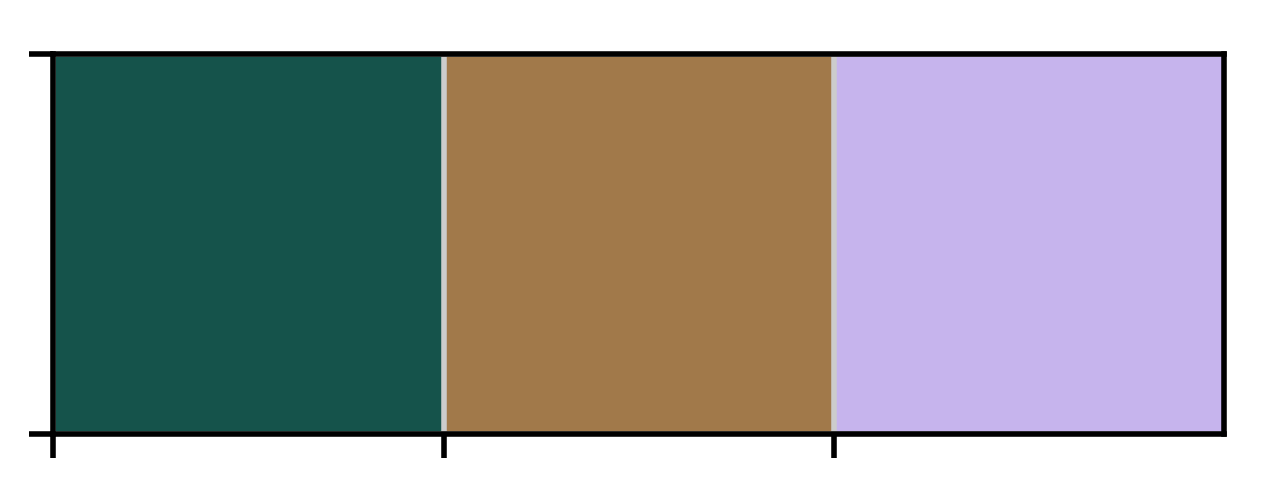

In [59]:
color_palette = sns.color_palette("cubehelix", 3)
sns.palplot(sns.color_palette("cubehelix", 3))

In [57]:
results_df = pd.DataFrame(columns=['tissue', 'k', 'prob', 'Correct', 'InCorrect', 'Unknown'])
for tissue in tissues:
    labels_eval_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'

    tissue_latent = valid_latent[valid_latent.obs['tissue'] == tissue]

    pred_labels = tissue_latent.obs[labels_eval_key].values
    true_labels = tissue_latent.obs[cell_type_key].values

    labels_eval = np.array(pred_labels) == np.array(true_labels)

    n_correct = len(labels_eval[labels_eval == True])
    n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
    n_unknown = len(labels_eval[pred_labels == 'Unknown'])
    
    new_row = {"tissue": f"{tissue} ({tissue_latent.shape[0]})", "k": n_neighbor, "prob": threshold}

    new_row['Correct'] = n_correct
    new_row['InCorrect'] = n_incorrect
    new_row['Unknown'] = n_unknown

    results_df = results_df.append(new_row, ignore_index=True)

In [60]:
results_df = results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(results_df, id_vars=['k', 'prob', 'tissue'], var_name='type', value_name='n_samples')
barplot = sns.catplot(x='tissue', y='n_samples', hue='type', data=results_df_melted, 
                      kind='bar', height=10, aspect=3, legend=False, palette=color_palette)


plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("")
plt.xlabel("")
plt.savefig(f"./results/classification/tabula_senis_muris/barplot_tissues.pdf", bbox_inches='tight')
results_df.to_csv("./results/classification/tabula_senis_muris/table_tissues.csv", index=None)
plt.show()
plt.close()

## Generate Sankey plots per tissue

In [13]:
valid_latent = sc.read("./results/classification/tabula_senis_muris/valid_latent.h5ad")
valid_latent

AnnData object with n_obs × n_vars = 90120 × 32 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'Tech', 'labels_evaluation_w_unknown_20_0.5', 'uncertainty_w_unknown_20_0.5', 'predicted_labels_w_unknown_20_0.5'

In [45]:
valid_latent.obs['tissue'].replace("Heart_and_Aorta", 'Heart', inplace=True)
valid_latent.obs['tissue'].replace("Aorta", 'Heart', inplace=True)

In [48]:
tissues = valid_latent.obs['tissue'].unique().tolist()

In [56]:
for tissue in tissues:
    print(f'{tissue}...', end='')
    labels_eval_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'
    
    tissue_latent = valid_latent[valid_latent.obs['tissue'] == tissue]
    cell_type_dict = tissue_latent.obs[cell_type_key].value_counts().to_dict()
    labels_eval_dict = tissue_latent.obs[labels_eval_key].value_counts().to_dict()
    
    tissue_latent.obs[cell_type_key] = tissue_latent.obs[cell_type_key].apply(lambda x: f'{x} ({cell_type_dict[x]})')
    tissue_latent.obs[labels_eval_key] = tissue_latent.obs[labels_eval_key].apply(lambda x: f'{x} ({labels_eval_dict[x]})')
    
    pred_labels = tissue_latent.obs[labels_eval_key].values
    true_labels = tissue_latent.obs[cell_type_key].values
    
    pred_labels = np.array(pred_labels).reshape(-1, 1)
    true_labels = np.array(true_labels).reshape(-1, 1)
    
    
        
    plot_data = np.concatenate([true_labels, pred_labels], axis=1)
    
    sn.pl.sankey_diagram(plot_data, v_gap_frac=0.1, h_gap_frac=0.03, figsize=(35, 21), x_range=(5, 20),
                              color_side=1, wdisp_sep=' ', labels=('', ''), disp_width=False,
                              cmap=matplotlib.cm.get_cmap('jet'),
                              save_path=f"./results/classification/tabula_senis_muris/sankey/sankey_{tissue}.pdf",
                              show=False,
                             )
    print("finished!")

Trying to set attribute `.obs` of view, making a copy.


Tongue...

Trying to set attribute `.obs` of view, making a copy.


finished!
Liver...

Trying to set attribute `.obs` of view, making a copy.


finished!
Bladder...

Trying to set attribute `.obs` of view, making a copy.


finished!
Kidney...

Trying to set attribute `.obs` of view, making a copy.


finished!
Spleen...

Trying to set attribute `.obs` of view, making a copy.


finished!
Thymus...

Trying to set attribute `.obs` of view, making a copy.


finished!
Mammary_Gland...

Trying to set attribute `.obs` of view, making a copy.


finished!
Limb_Muscle...

Trying to set attribute `.obs` of view, making a copy.


finished!
Marrow...

Trying to set attribute `.obs` of view, making a copy.


finished!
Heart...

Trying to set attribute `.obs` of view, making a copy.


finished!
Lung...

Trying to set attribute `.obs` of view, making a copy.


finished!
Trachea...

Trying to set attribute `.obs` of view, making a copy.


finished!
Skin...

Trying to set attribute `.obs` of view, making a copy.


finished!
SCAT...

Trying to set attribute `.obs` of view, making a copy.


finished!
Brain_Myeloid...

Trying to set attribute `.obs` of view, making a copy.


finished!
MAT...

Trying to set attribute `.obs` of view, making a copy.


finished!
Diaphragm...

Trying to set attribute `.obs` of view, making a copy.


finished!
Brain_Non-Myeloid...

Trying to set attribute `.obs` of view, making a copy.


finished!
GAT...

Trying to set attribute `.obs` of view, making a copy.


finished!
BAT...

Trying to set attribute `.obs` of view, making a copy.


finished!
Pancreas...

Trying to set attribute `.obs` of view, making a copy.


finished!
Large_Intestine...finished!
